<a href="https://colab.research.google.com/github/jaysulk/uic_fnal_linac_phase_comp/blob/Sulskis-dev/network_2cav_T2T5_v2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tank2 and Tank5 phase regulation

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive

/content/drive


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.mixture
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["savefig.format"] = 'pdf'
plt.rc("axes",prop_cycle= plt.cycler("color", plt.cm.tab20.colors))

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
import torchvision.transforms as transforms
from PIL import Image

preprocessing = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## DNN regression models

The base model contains the following layers:

* The normalization layer.
* N hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear output layer.

We also test a model without input normalization layer.

#PyTorch conversion

* Layers: Dense layers are converted to nn.Linear, and ReLU activations remain as nn.ReLU().
* Batch Normalization: Keras BatchNormalization is replaced with nn.BatchNorm1d.
* Optimizers: tf.keras.optimizers.Adam is converted to torch.optim.Adam.
* Loss function: mean_squared_error is mapped to nn.MSELoss().
* Normalization: In Keras, you have norm as an input. In PyTorch, you might need to preprocess input tensors separately.
* LSTM Model: In PyTorch, LSTMs need explicit handling of sequences and hidden states.


In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, numlabel=1, use_batchnorm=True):
        super(MLP, self).__init__()
        layers = []

        layers.append(nn.Linear(input_dim, 32))
        layers.append(nn.ReLU())
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(32))

        layers.append(nn.Linear(32, 64))
        layers.append(nn.ReLU())
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(64))

        layers.append(nn.Linear(64, 128))
        layers.append(nn.ReLU())
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(128))

        layers.append(nn.Linear(128, 64))
        layers.append(nn.ReLU())
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(64))

        layers.append(nn.Linear(64, 32))
        layers.append(nn.ReLU())
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(32))

        layers.append(nn.Linear(32, numlabel))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
def build_and_compile_model_len(input_dim, init_lr, numlabel):
    model = MLP(input_dim, numlabel=numlabel)
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

def build_and_compile_model_square(input_dim, init_lr):
    class SquareMLP(nn.Module):
        def __init__(self):
            super(SquareMLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Linear(128, 1)
            )

        def forward(self, x):
            return self.model(x)

    model = SquareMLP()
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

def build_and_compile_model_nobatch(input_dim, init_lr):
    class NoBatchMLP(nn.Module):
        def __init__(self):
            super(NoBatchMLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )

        def forward(self, x):
            return self.model(x)

    model = NoBatchMLP()
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

def build_and_compile_model_nonorm(input_dim, init_lr):
    class NoNormMLP(nn.Module):
        def __init__(self):
            super(NoNormMLP, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 100),
                nn.ReLU(),
                nn.Linear(100, 1)
            )

        def forward(self, x):
            return self.model(x)

    model = NoNormMLP()
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, numlabel):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, 128, batch_first=True, return_sequences=True)
        self.lstm2 = nn.LSTM(128, 128, batch_first=True)
        self.fc = nn.Linear(128, numlabel)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])  # Take the output from the last time step
        return x

In [10]:
def build_and_compile_model_LSTM(input_dim, init_lr, numlabel):
    model = LSTMModel(input_dim, numlabel)
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

## Define learning schedules and training

In [11]:
# Define learning schedules

initial_lr = 0.001

def lr_time_based_decay(epoch, lr):
    epochs = 400
    decay = initial_lr / epochs
    return lr * 1 / (1 + decay * epoch)


def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 200.0
    return initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return initial_lr * math.exp(-k*epoch)



In [12]:
def train_model(model,features,labels,eps,lrs=None):
    if lrs is None:
        history = model.fit(
            features,
            labels,
            validation_split=0.2,
            batch_size=64, #30
            verbose=0,
            epochs=int(eps)
        )
    else:
        history = model.fit(
            features,
            labels,
            validation_split=0.2,
            batch_size=64,
            verbose=0,
            epochs=int(eps),
            callbacks=[LearningRateScheduler(lrs, verbose=0)],
        )
    return history

## Define plotting functions

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

def plot_multi_loss(histories):
    fig, ax = plt.subplots(len(histories),1,figsize=(9,9))
    for i in range(len(histories)):
        ax[i].plot(histories[i].history['loss'], label='loss')
        ax[i].plot(histories[i].history['val_loss'], label='val_loss')
        ax[i].set_ylim([0, 0.5])
        ax[i].set(xlabel='Epoch', ylabel='Loss')
        ax[i].legend()
        ax[i].grid(True)

    fig.tight_layout()


In [14]:
def plot_2dhist(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    fig.tight_layout()
    devs = ['DTL2','DTL5']

    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        #key = labels.columns[i]
        key = devs[i]
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        h = ax[i].hist2d(labels.iloc[:,i], predictions[:,i], bins=40, cmin=1, cmap='winter')
        #ax.set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        ax[i].set(title='%s'%key)
        ax[i].tick_params(axis='both',labelsize='x-large')
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        ax[i].plot(lims, lims, color='k')
        fig.colorbar(h[3], ax=ax[i])

    fig.supylabel('Predicted $\Delta\phi_{RF}$ (deg)', fontsize='x-large')
    fig.suptitle('True $\Delta\phi_{RF}$ (deg)', y=0.05, fontsize='x-large')
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.subplots_adjust(bottom=0.20)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.14)
    plt.subplots_adjust(right=0.96)

In [15]:
def plot_2dscatter_many(predictions,labels):

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5))
    if labels[0].shape[1] ==1:
        ax = [ax]

    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]

        for j in range(len(labels)):
            ax[i].scatter(labels[j].iloc[:,i], predictions[j][:,i], label='Data %d'%j)
            #ax[i].fill_between(labels[j].iloc[:,i],[np.min(predictions[j][k,i]) for k in ],np.max(predictions[j][:,i]),alpha=0.5)
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min([np.min(pred[:,i]) for pred in predictions]),np.min([np.min(lab.iloc[:,i]) for lab in labels])),
                max(np.max([np.max(pred[:,i]) for pred in predictions]),np.max([np.max(lab.iloc[:,i]) for lab in labels]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        #print(lims)
        ax[i].plot(lims, lims, color='b')
        ax[i].legend(ncol=2,fontsize=14, loc='upper left')
    fig.tight_layout()

In [16]:
def plot_2dscatter(predictions,labels):

    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5))
    if labels.shape[1] ==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        key = labels.columns[i]
        ax[i].scatter(labels.iloc[:,i], predictions[:,i], color='r')
        ax[i].set(xlabel='True Values %s'%key, ylabel='Predictions %s'%key)
        lims = [min(np.min(predictions[:,i]),np.min(labels.iloc[:,i])),
                max(np.max(predictions[:,i]),np.max(labels.iloc[:,i]))]
        ax[i].set_xlim(lims)
        ax[i].set_ylim(lims)
        print(lims)
        ax[i].plot(lims, lims, color='b')
    fig.tight_layout()

In [17]:
def plot_1derror(predictions,labels):

    props = dict(boxstyle='round', facecolor='white', alpha=0.4)
    devs = ['DTL2','DTL5']
    fig, ax = plt.subplots(1,int(labels.shape[1]), figsize=(5*int(labels.shape[1]),5),sharey=False)
    fig.tight_layout()

    nbins=60
    if labels.shape[1]==1:
        ax = [ax]
    for i in range(labels.shape[1]):
        #key = labels.columns[i]
        key = devs[i]
        error =(predictions[:,i] - labels.iloc[:,i])
        error = [e for e in error if e <3*np.std(error)]

        ax[i].hist(error, bins=nbins, color='b', edgecolor='k', alpha=0.65, label='Data')
        #ax[i].set(title='%s'%key ,xlabel='Prediction Error (deg)', ylabel='Count')
        ax[i].set(title='%s'%key)
        #ax[i].xaxis.label.set_size(13)
        #ax[i].yaxis.label.set_size(13)

        ers = np.array(error)[:,None]
        gmm = sklearn.mixture.GaussianMixture()
        r = gmm.fit(ers)
        mean = r.means_[0, 0]
        sigma = np.sqrt(r.covariances_[0,0])
        textstr = '\n'.join((
                    r'$\mu=%.2f$' % (mean,),
                    r'$\sigma=%.2f$' % (sigma,)))
        print(textstr)
        xlin = np.linspace(np.min(error),np.max(error),1000).reshape(-1,1)
        pdf = np.exp(gmm.score_samples(xlin))
        binsize = (np.max(error) - np.min(error))/nbins
        ax[i].plot(xlin,pdf*(len(error)*binsize),color='k', label='Gauss fit')
        ax[i].text(0.05, 0.65, textstr, transform=ax[i].transAxes, color='k', fontsize='large',
                           verticalalignment='top', bbox=props)
        ax[i].legend(fontsize='large', loc='upper left')
        ax[i].tick_params(axis='both',labelsize='x-large')

    fig.supylabel('Entries/Bin', fontsize='x-large')
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize='x-large')
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.10)
    plt.subplots_adjust(right=0.96)


In [18]:
def plot_1derror_many(predictions,labels):

    props = dict(boxstyle='round', facecolor='white', alpha=0.4)

    fig, ax = plt.subplots(1,int(labels[0].shape[1]), figsize=(5*int(labels[0].shape[1]),5),sharey=False)
    fig.tight_layout()
    if labels[0].shape[1]==1:
        ax = [ax]
    for i in range(labels[0].shape[1]):
        key = labels[0].columns[i]
        nbins=40
        for j in range(len(labels)):
            error =(predictions[j][:,i] - labels[j].iloc[:,i])
            error = [e for e in error if e <1*np.std(error)]
            if i not in[2,3]:
                ax[i].hist(error, bins=nbins, alpha=0.45, label='Data')
            else:
                ax[i].hist(error, bins=100, alpha=0.45, label='Data')
        ax[i].set(title='%s'%key)
        #ax[i].legend(fontsize=14, loc='upper left')
        ax[i].tick_params(axis='both',labelsize='x-large')

    fig.supylabel('Entries/Bin', fontsize='x-large')
    fig.suptitle('Prediction error (degrees)', y=0.05, fontsize='x-large')
    plt.subplots_adjust(wspace=0.19, hspace=0)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(top=0.92)
    plt.subplots_adjust(left=0.09)
    plt.subplots_adjust(right=0.96)


## Define data loading functions

In [19]:
def fetch_data(file,datacols,cuts,setdevs):
    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    # augment jumps in phase data
    #subset['B:BQ3F'] = subset['B:BQF3'].apply(lambda x : x if x > 0 else x +360)
    subset.dropna()

    return subset

In [20]:
def fetch_reference(dataset,devs,setvals,stepsize):

    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    #reference = dataset.loc[(np.abs(dataset[devs[0]]-setvals[0])<0.5)].mean()
    reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()
    return reference

In [21]:
def fetch_slice(dataset,devs,setvals,stepsize):

    conds = ["(np.abs(dataset['%s']-%s)<%f)"%(d,s,k) for (d,s,k) in zip(devs,setvals,stepsize)]

    sliced = dataset.loc[eval('&'.join(conds)).ravel()]
    return sliced

In [22]:
def fetch_features_labels(dataset,targetdevs):
    features = dataset.copy()
    labelstr = list(dataset.filter(regex='|'.join(targetdevs)))
    labels = features.loc[:,labelstr]
    features.drop(columns=labelstr, inplace=True)

    return features,labels

In [23]:
# List of approximate BPM positions in meters
dist_data = [26.5,27.0, 43.5, 44.0,60.8, 77.0,78.3,79.6,
            80.8, 82.5, 84.4,
            88.2, 90.1, 92.1,
            96.3, 98.4, 100.6, 102.8,
            105.0, 109.6, 111.9,
            114.7, 116.7, 119.1, 121.6,
            124.0, 126.5, 129.6, 131.6,
            134.2, 136.8, 139.4, 141.6]
#D42 : 107.3

## 2-phase models: T2, T5 setting

In [24]:
onedegdata = 'MyDrive/PhaseCompensation/devicescan_26042023.csv'
path = r'MyDrive/PhaseCompensation/'
files =['rfq_t2_t5_14122022.csv','devicescan_rfq_t2_t5.csv']
cavs = ['L:RFQPAH','L:V2QSET','L:V5QSET']
#cavs = ['L:V2QSET','L:V5QSET']

dfs = [fetch_data('%s%s'%(path,f),cavs+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs]) for f in files]

dfs = [df.drop(list(df.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1) for df in dfs]


# quality cuts
dfs[0].iloc[0,:] = dfs[0].iloc[1,:]
dfs[0].iloc[99,:] = dfs[0].iloc[100,:]
dfs[0].iloc[297,:] = dfs[0].iloc[298,:]
dfs[0].iloc[1386,:] = dfs[0].iloc[1387,:]
dfs[0].iloc[1477,:] = dfs[0].iloc[1478,:]
dfs[0].iloc[1683,:] = dfs[0].iloc[1684,:]
dfs[0].iloc[1738,:] = dfs[0].iloc[1739,:]
dfs[0].iloc[2574,:] = dfs[0].iloc[2575,:]
dfs[0].iloc[2673,:] = dfs[0].iloc[2674,:]
dfs[0].iloc[2970,:] = dfs[0].iloc[2971,:]
dfs[0].iloc[3960,:] = dfs[0].iloc[3961,:]
dfs[0].iloc[3982,:] = dfs[0].iloc[3983,:]
dfs[0].iloc[4950,:] = dfs[0].iloc[4951,:]
dfs[0].iloc[5346,:] = dfs[0].iloc[5347,:]
dfs[0].iloc[5445,:] = dfs[0].iloc[5446,:]
dfs[0].iloc[5841,:] = dfs[0].iloc[5842,:]
dfs[0].iloc[5940,:] = dfs[0].iloc[5941,:]
dfs[0].iloc[6435,:] = dfs[0].iloc[6436,:]
dfs[0].iloc[6534,:] = dfs[0].iloc[6535,:]
dfs[0].iloc[7128,:] = dfs[0].iloc[7129,:]
dfs[0].iloc[7326,:] = dfs[0].iloc[7327,:]
dfs[0].iloc[7623,:] = dfs[0].iloc[7624,:]
dfs[0].iloc[7821,:] = dfs[0].iloc[7822,:]
dfs[0].iloc[8118,:] = dfs[0].iloc[8119,:]
dfs[0].iloc[8910,:] = dfs[0].iloc[8911,:]
dfs[0].iloc[9207,:] = dfs[0].iloc[9208,:]
dfs[0].iloc[9306,:] = dfs[0].iloc[9307,:]
dfs[0].iloc[9603,:] = dfs[0].iloc[9604,:]
dfs[0].iloc[9801,:] = dfs[0].iloc[9802,:]
dfs[0].iloc[10098,:] = dfs[0].iloc[10099,:]
dfs[0].iloc[10494,:] = dfs[0].iloc[10495,:]
dfs[0].iloc[10890,:] = dfs[0].iloc[10891,:]
dfs[0].iloc[10989,:] = dfs[0].iloc[10990,:]
dfs[0].iloc[11088,:] = dfs[0].iloc[11089,:]
dfs[0].iloc[11286,:] = dfs[0].iloc[11287,:]
dfs[0].iloc[11884,:] = dfs[0].iloc[11885,:]
dfs[0] = dfs[0].iloc[:-1,:]


dfs[0] = dfs[0].loc[(dfs[0]['L:BPM3OF']>0)&
                    (dfs[0]['L:BPM4IF']>0) & (dfs[0]['L:BPM5IF']<-87) & (dfs[0]['L:D13BF']<-17.5)&
                    (dfs[0]['L:D41BF']<-150)& (dfs[0]['L:D52BF']<-44)& (dfs[0]['L:D72BF']<-65)]

dfs[1].iloc[0,:] = dfs[1].iloc[1,:]
dfs[1].iloc[5940] = dfs[1].iloc[5941]
dfs[1] = dfs[1].iloc[:-1,:]

meds = [[np.median(df[c]) for c in cavs] for df in dfs]
#meds[0] = [178.57666015625, -26.5, -31.715069]
print(meds)

stepsize = [[3.,0.5,0.2],[3.9,0.35,0.4]]

refs = [fetch_reference(df,cavs,med,step) for df,med,step in zip(dfs,meds,stepsize)]
test = fetch_slice(dfs[0],cavs,meds[0],stepsize[0])
#print(refs)
ddfs = [df-ref for df,ref in zip(dfs,refs)]


df1deg = fetch_data('%s'%onedegdata,cavs[1:]+['BF','BPM'],'',['%s_R'%c[2:] for c in cavs[1:]])
df1deg = df1deg.drop(list(df1deg.filter(regex=r'20|B:|SS|SQT|2OF|D42')),axis=1)
df1deg = df1deg.iloc[:-1,:]
df1deg['L:BPM5OF'] = df1deg['L:BPM5OF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D53BF'] = df1deg['L:D53BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D33BF'] = df1deg['L:D33BF'].apply(lambda x : x if x > 0 else x +360)
df1deg['L:D41BF'] = df1deg['L:D41BF'].apply(lambda x : x if x > 0 else x +360)
df1deg = df1deg.loc[(df1deg['L:D72BF']<-65) & (df1deg['L:BPM4IF']>95) & (df1deg['L:D23BF']<100)]

ref1deg =fetch_reference(df1deg,cavs[1:],[np.median(df1deg[c]) for c in cavs[1:]],[0.99,0.99])
ddf1deg = df1deg-ref1deg

#ref1deg

[[178.57666015625, -26.5, -32.40999984741211], [180.2978515625, -26.5, -34.280033111572266]]


<ipython-input-20-0a503e90ac0b>:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()
<ipython-input-21-594ebfea2ea7>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sliced = dataset.loc[eval('&'.join(conds)).ravel()]
<ipython-input-20-0a503e90ac0b>:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  reference = dataset.loc[eval('&'.join(conds)).ravel()].mean()


OSError: [Errno 95] Operation not supported: 'bpm_data_BPM3IF.png'

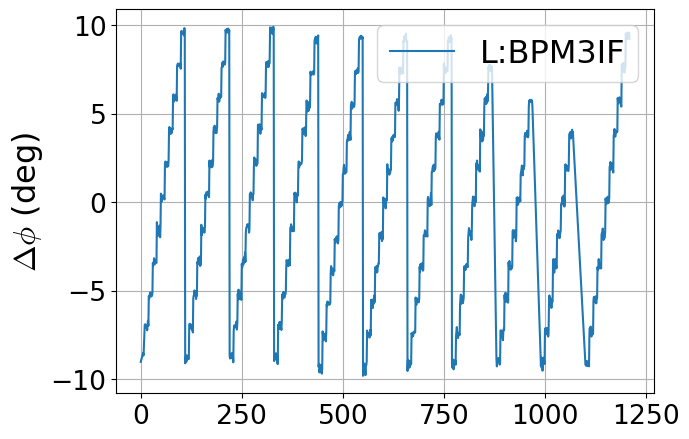

In [31]:
#%matplotlib widget
%matplotlib inline
plt.rcParams.update({'font.size': 16, 'font.family': "Times New Roman",
                     'mathtext.fontset': 'cm', 'savefig.format' : 'pdf',
                    'axes.labelsize': 'x-large',
                    'axes.titlesize':'x-large',
                    'xtick.labelsize':'large',
                    'ytick.labelsize':'large',})

#[plt.plot(ddf1deg.iloc[k,3:], label='$\Delta\phi_{DTL2}$=%2.1f'%(ddf1deg.iloc[k,1]), marker='',linestyle='-') for k in [0,11,121]];
#fig = plt.figure()
#ax = fig.add_subplot()
#ax = fig.add_subplot(projection='3d')
#ax.scatter(ddf1deg['L:V2QSET'],ddf1deg['L:BPM3OF'],ddf1deg['L:V5QSET'])
#ax.scatter(ddf1deg['L:V2QSET'],ddf1deg['L:BPM5OF'],ddf1deg['L:V5QSET'])
for col in list(ddf1deg.columns)[2:]:
    plt.cla()
    plt.plot(ddf1deg[col],label='%s'%col);
    plt.legend(loc="upper right",fontsize = 'x-large',ncol=1);
    plt.subplots_adjust(bottom=0.15)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.15)
    plt.subplots_adjust(right=0.99)
    plt.grid()
    #plt.xlabel("")
    plt.ylabel("$\Delta \phi$ (deg)")
    plt.savefig('bpm_data_%s.png'%col[2:])
#plt.xticks(rotation = 90);

Text(0, 0.5, 'L:V5QSET')

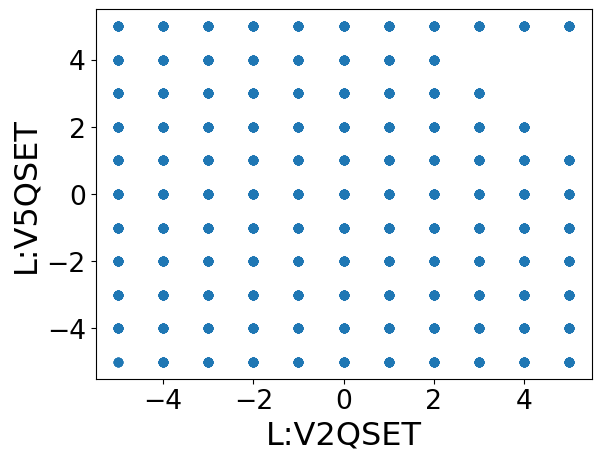

In [30]:
%matplotlib inline
plt.scatter(ddf1deg.iloc[:,0],ddf1deg.iloc[:,1])
plt.xlabel(list(df1deg.columns)[0])
plt.ylabel(list(df1deg.columns)[1])

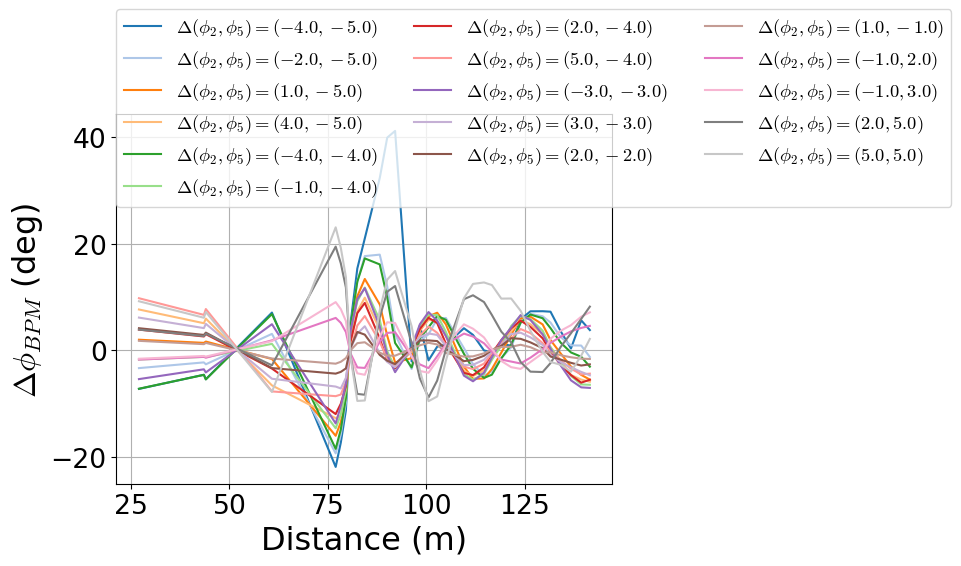

In [32]:
#%matplotlib widget
%matplotlib inline
df1degavg =df1deg.groupby(np.arange(len(df1deg))//10).mean()
ll=[10,30,60,90,120,150,180,210,240,300,400,500,800,900,1100,1137]
[plt.plot(dist_data[1:],ddf1deg.iloc[k,2:],label='$\Delta(\phi_2,\phi_5)=(%.1f,%.1f)$'%(ddf1deg.iloc[k,0],ddf1deg.iloc[k,1]))for k in ll]
#plt.xticks(rotation = 90);
#plt.legend(loc="lower right",fontsize = 'small',ncol=3,bbox_to_anchor=(1.,1))
plt.legend(ncol=3,bbox_to_anchor=(0., .75, .95, .99),fontsize='small',loc='lower left',borderaxespad=0.)
plt.ylabel('$\Delta\phi_{BPM}$ (deg)')
plt.xlabel('Distance (m)')
plt.grid()

In [33]:
ddf1deg.shape[0]*0.8

910.4000000000001

(1085, 35)
(99, 35)


,L:RFQPAH,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,158.581543,-26.5,-32.41,87.478638,76.783447,97.426758,-94.768066,16.820068,-59.776611,-91.862183,...,-0.175781,-135.401001,2.460938,-104.677734,29.536743,41.160278,97.871704,-72.910767,103.601074,105.133667
1,158.581543,-26.5,-32.41,87.478638,76.783447,97.426758,-94.768066,16.820068,-59.776611,-91.862183,...,-0.175781,-135.401001,2.460938,-104.677734,29.536743,41.160278,97.871704,-72.910767,103.601074,105.133667
2,158.581543,-26.5,-32.41,87.385254,76.838379,97.283936,-94.246216,16.402588,-60.133667,-92.647705,...,-0.027466,-134.983521,2.807007,-104.441528,29.102783,40.720825,97.520142,-73.970947,103.211060,104.529419
3,158.581543,-26.5,-32.41,87.160034,76.657104,97.168579,-94.416504,16.633301,-59.826050,-91.950073,...,-0.164795,-135.159302,2.702637,-104.512939,29.344482,41.099854,97.739868,-73.020630,103.397827,104.705200
4,158.581543,-26.5,-32.41,87.110596,76.684570,97.108154,-94.740601,16.962891,-59.551392,-91.829224,...,-0.428467,-135.318604,2.466431,-104.567871,29.130249,40.869141,97.855225,-72.800903,103.606567,104.831543
5,158.581543,-26.5,-32.41,87.182007,76.684570,97.190552,-94.735107,16.770630,-59.683228,-92.043457,...,-0.241699,-135.659180,2.625732,-104.458008,29.218140,40.753784,97.822266,-73.031616,103.507690,104.853516
6,158.581543,-26.5,-32.41,86.742554,76.343994,96.893921,-94.685669,16.737671,-59.584351,-91.658936,...,-0.120850,-135.258179,2.559814,-104.694214,29.317017,41.099854,97.728882,-72.987671,103.452759,105.034790
7,158.581543,-26.5,-32.41,87.066650,76.569214,96.943359,-94.064941,16.369629,-60.139160,-92.389526,...,-0.285645,-135.604248,2.796021,-104.315186,29.388428,40.638428,97.679443,-74.031372,103.260498,104.551392
8,158.581543,-26.5,-32.41,87.072144,76.635132,97.075195,-94.548340,16.704712,-60.139160,-92.389526,...,-0.285645,-135.604248,2.796021,-104.315186,29.388428,40.638428,97.679443,-74.031372,103.260498,104.551392
9,162.579346,-26.5,-32.41,87.692871,76.920776,97.531128,-94.548340,16.891479,-59.853516,-92.087402,...,-0.351562,-135.626221,2.691650,-104.359131,29.371948,40.638428,97.728882,-73.163452,103.315430,104.644775


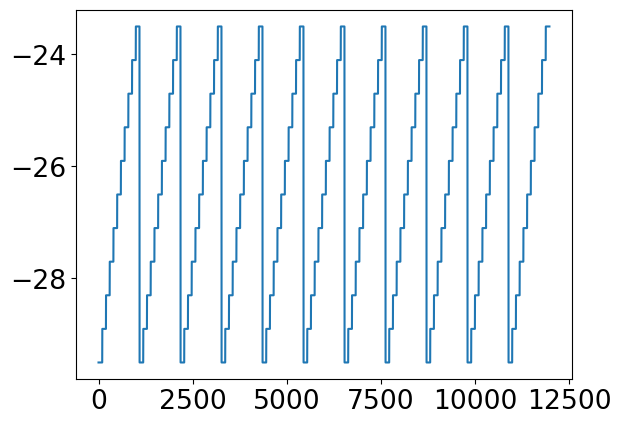

In [34]:
%matplotlib inline
plt.plot(dfs[0]['L:V2QSET'])
dff = dfs[0].loc[np.abs(dfs[0]['L:RFQPAH']-178.57)<1.]

dff =dff.sort_index().reset_index(drop=True)
dff.dropna(inplace=True)

print(dff.shape)
dff.head(10)
#dff.to_csv('training_t2t5_oscillation.csv')

dfff = dfs[0].loc[(np.abs(dfs[0]['L:V2QSET']+26.5)<0.5) & (np.abs(dfs[0]['L:V5QSET']+32.41)<0.3)]
#dfff = dfs[0].loc[(np.abs(dfs[0]['L:V2QSET']-26.5)<0.3)]
dfff =dfff.sort_index().reset_index(drop=True)
dfff.dropna(inplace=True)
print(dfff.shape)
dfff.head(10)
#dfff.to_csv('testing_upstream_oscillation.csv')


In [37]:
bpm = list(dff.columns)[3:]
res = dict(zip(bpm, dist_data))
import json

with open('MyDrive/sensor_positions.json', 'w') as fp:
    json.dump(res, fp)

baseline = dict(zip(cavs,meds[0]))
print(baseline)
with open('MyDrive/baseline_knobs.json', 'w') as fp:
    json.dump(baseline, fp)

{'L:RFQPAH': 178.57666015625, 'L:V2QSET': -26.5, 'L:V5QSET': -32.40999984741211}


## Plot BPM phase oscillation

In [38]:
ssdf = []
for i in range(3):
    cav = [c for c in cavs if c!=cavs[i]]
    ssdf.append([fetch_slice(df,cav,[0.,0.],[0.3,0.3]) for df in ddfs])
    #ssdf.append([fetch_slice(df,cav,[0.,0.],[0.9,0.9]) for df in ddfs])

ssdf =[[df.sort_index().reset_index(drop=True) for df in s] for s in ssdf]
ssdf = [[df.dropna() for df in s] for s in ssdf]

ssdf[0][1].drop([99],inplace=True)

print([[df.shape for df in s] for s in ssdf])

ssdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
#ssdfmed= [[df.groupby(np.arange(len(df))//10).mean() for df in s] for s in ssdf]
print([[df.shape for df in s] for s in ssdfmed])

[[(99, 35), (99, 35)], [(98, 35), (99, 35)], [(98, 35), (99, 35)]]
[[(11, 35), (11, 35)], [(11, 35), (11, 35)], [(11, 35), (11, 35)]]


<ipython-input-21-594ebfea2ea7>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sliced = dataset.loc[eval('&'.join(conds)).ravel()]


In [39]:
ssdf1 = []
for i in range(2):
    cav = [c for c in cavs[1:] if c!=cavs[i]]
    ssdf1.append(fetch_slice(ddf1deg,cav,[0.],[0.9]))

ssdf1 =[df.sort_index().reset_index(drop=True) for df in ssdf1]
ssdf1 = [df.dropna() for df in ssdf1]

ssdfmed1= [df.groupby(np.arange(len(df))//10).median() for df in ssdf1]
ssdfmed1[1]

<ipython-input-21-594ebfea2ea7>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sliced = dataset.loc[eval('&'.join(conds)).ravel()]


,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,L:D11BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,-5.0,0.0,-9.234558,-5.834839,-6.962036,8.906616,-6.219910,-4.147888,-1.985779,3.055298,...,2.903137,3.919373,3.949036,2.236816,-0.037354,-2.025879,-3.398071,-4.373108,-4.918579,-4.113831
1,-4.0,0.0,-7.430054,-4.793884,-5.684875,7.099365,-5.211914,-3.186584,-1.576538,2.519714,...,2.449951,3.208008,3.023438,1.528198,-0.333984,-1.896790,-2.881714,-3.458496,-3.789734,-3.300842
2,-3.0,0.0,-5.724426,-3.796875,-4.484619,5.294861,-3.772705,-2.332397,-1.071167,1.962158,...,1.955566,2.381287,2.177490,0.984375,-0.416382,-1.526001,-2.299438,-2.692200,-2.941040,-2.457642
3,-2.0,0.0,-3.689209,-2.505981,-2.899841,3.278870,-2.308777,-1.398560,-0.579529,1.346924,...,1.277161,1.439209,1.306824,0.498230,-0.397156,-1.048096,-1.475464,-1.634766,-1.828674,-1.471619
4,-1.0,0.0,-1.964355,-1.327698,-1.565002,1.617188,-1.149719,-0.706421,-0.266418,0.739929,...,0.650940,0.834961,0.675110,0.220825,-0.292786,-0.446594,-0.810791,-0.876709,-1.012939,-0.859131
5,0.0,0.0,0.015930,0.064819,0.028015,0.013184,-0.023621,-0.039001,0.035706,0.108215,...,-0.008240,-0.065918,-0.044495,0.017578,0.023071,0.020325,0.029663,0.065369,-0.018677,0.096680
6,1.0,0.0,1.806702,1.179932,1.404053,-1.552368,1.009094,0.680603,0.263672,-0.605896,...,-0.601501,-0.601501,-0.472961,-0.144470,0.143921,0.641052,0.686096,0.752014,0.827271,0.470215
7,2.0,0.0,3.666138,2.492798,2.922913,-3.205811,2.231323,1.350769,0.299377,-1.116760,...,-1.343079,-1.230469,-1.057983,-0.295532,0.641052,1.099731,1.474365,1.801208,1.851746,1.763855
8,3.0,0.0,5.575012,3.764465,4.367615,-4.785095,3.291504,2.070374,0.738831,-1.830872,...,-1.933594,-1.947327,-1.480957,-0.350464,0.877258,1.863281,2.196716,2.592224,2.678467,2.697693
9,4.0,0.0,7.382263,4.931763,5.699707,-6.309448,4.703247,2.814697,1.060181,-2.418640,...,-2.455444,-2.573547,-1.978088,-0.515259,1.042053,2.289001,2.960266,3.493103,3.711182,3.576599


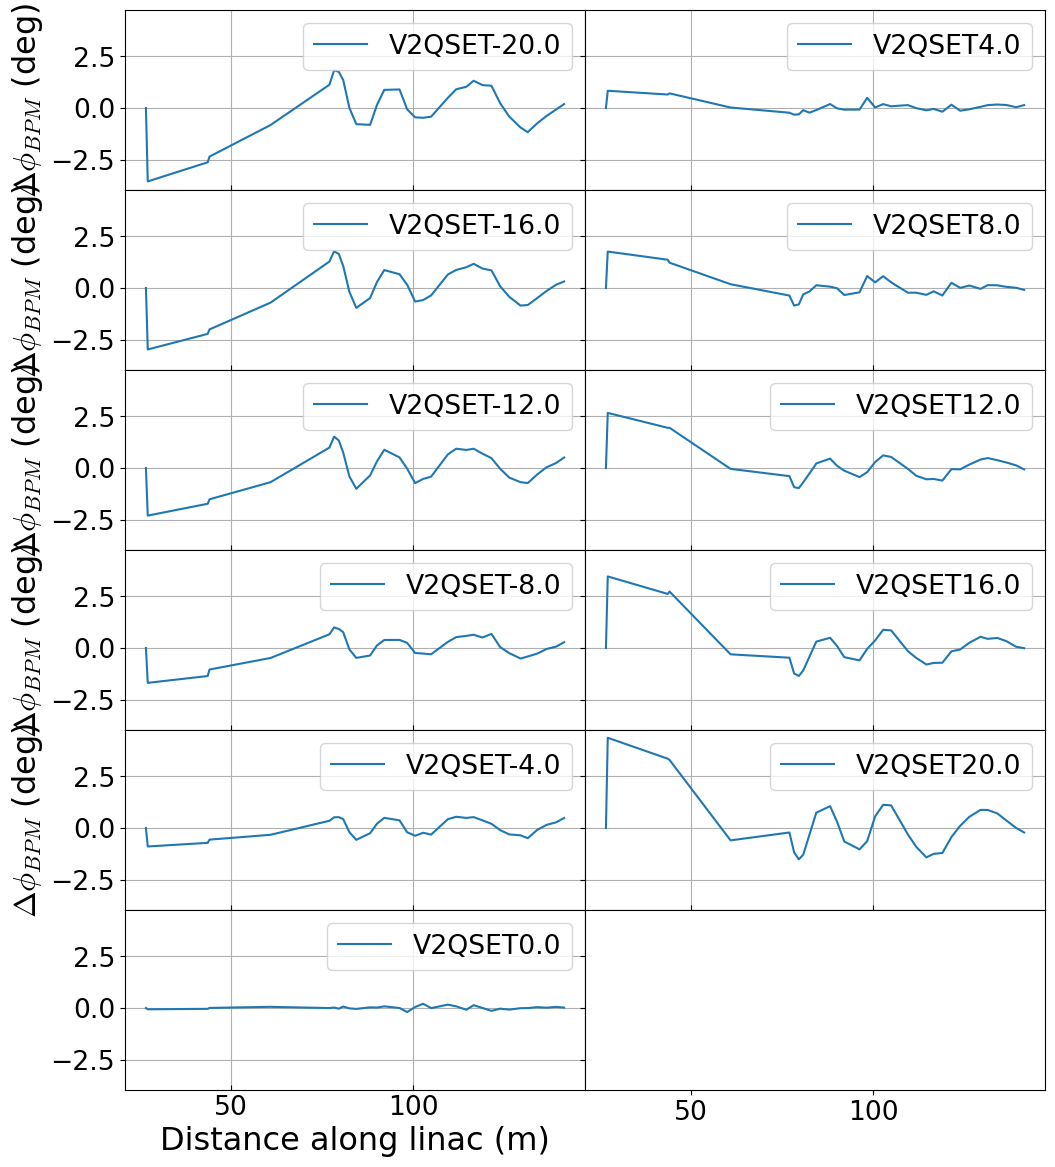

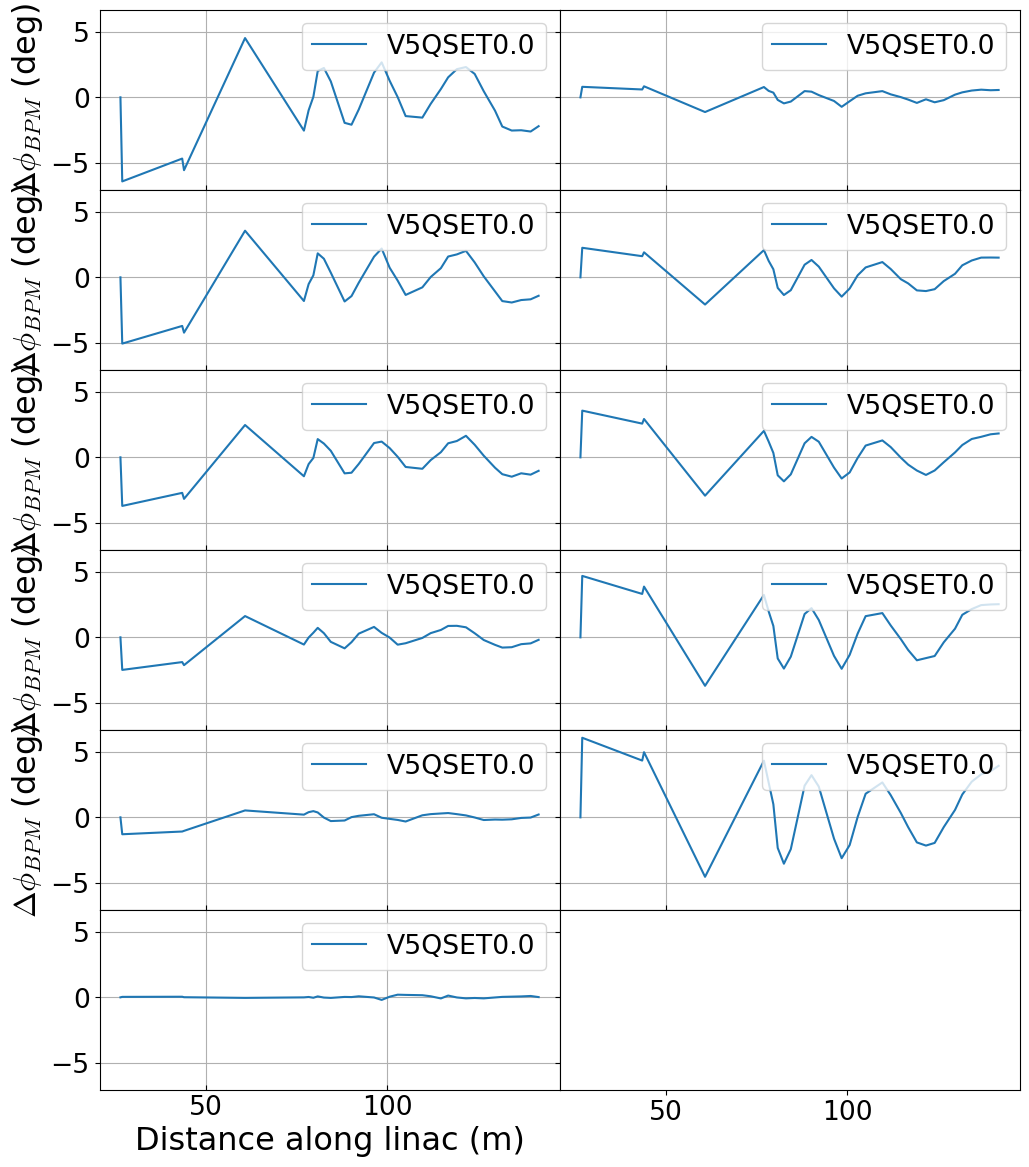

In [40]:
#%matplotlib widget
%matplotlib inline
nplots = ssdfmed[0][0].shape[0]
nrows = int(nplots/2) if nplots%2==0 else int(nplots/2)+1

#devs = ['RFQPAH','V2QSET','V5QSET']
devs = ['V2QSET','V5QSET']
for i in range(2):
    fig, axs = plt.subplots(nrows,2, figsize=(10,12), sharex=True, sharey=True)
    for k in range(nplots):
        axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][0].iloc[k,2:], label='%s%.1f'%(devs[i],ssdfmed[i][0].iloc[k,0]), marker='',linestyle='-')
        #axs[int(k%(nplots/2))][int(k/(nplots/2))].plot(dist_data,ssdfmed[i][1].iloc[k,2:], label='%s%.1f'%(devs[i],ssdfmed[i][1].iloc[k,2]), marker='o',linestyle='-')

        axs[int(k%(nplots/2))][int(k*2/(nplots))].legend(loc='upper right', fancybox=True, fontsize='large')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].xaxis.set_tick_params(direction='in', which='major')
        axs[int(k%(nplots/2))][int(k*2/(nplots))].grid(True)
        #axs[int(k%(nplots/2))][int(k*2/(nplots))].set_ylim(-4.,5)
        if int(k%(nplots/2))==nrows-1:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(xlabel='Distance along linac (m)')
        elif int(k/(nplots/2))%2==0:
            axs[int(k%(nplots/2))][int(k/(nplots/2))].set(ylabel='$\Delta \phi_{BPM}$ (deg)')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(bottom=0.05)
    plt.subplots_adjust(top=0.95)
    plt.subplots_adjust(left=0.06)
    plt.subplots_adjust(right=0.98)

In [41]:
ssdfmed1[1]

,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,L:D11BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,-5.0,0.0,-9.234558,-5.834839,-6.962036,8.906616,-6.219910,-4.147888,-1.985779,3.055298,...,2.903137,3.919373,3.949036,2.236816,-0.037354,-2.025879,-3.398071,-4.373108,-4.918579,-4.113831
1,-4.0,0.0,-7.430054,-4.793884,-5.684875,7.099365,-5.211914,-3.186584,-1.576538,2.519714,...,2.449951,3.208008,3.023438,1.528198,-0.333984,-1.896790,-2.881714,-3.458496,-3.789734,-3.300842
2,-3.0,0.0,-5.724426,-3.796875,-4.484619,5.294861,-3.772705,-2.332397,-1.071167,1.962158,...,1.955566,2.381287,2.177490,0.984375,-0.416382,-1.526001,-2.299438,-2.692200,-2.941040,-2.457642
3,-2.0,0.0,-3.689209,-2.505981,-2.899841,3.278870,-2.308777,-1.398560,-0.579529,1.346924,...,1.277161,1.439209,1.306824,0.498230,-0.397156,-1.048096,-1.475464,-1.634766,-1.828674,-1.471619
4,-1.0,0.0,-1.964355,-1.327698,-1.565002,1.617188,-1.149719,-0.706421,-0.266418,0.739929,...,0.650940,0.834961,0.675110,0.220825,-0.292786,-0.446594,-0.810791,-0.876709,-1.012939,-0.859131
5,0.0,0.0,0.015930,0.064819,0.028015,0.013184,-0.023621,-0.039001,0.035706,0.108215,...,-0.008240,-0.065918,-0.044495,0.017578,0.023071,0.020325,0.029663,0.065369,-0.018677,0.096680
6,1.0,0.0,1.806702,1.179932,1.404053,-1.552368,1.009094,0.680603,0.263672,-0.605896,...,-0.601501,-0.601501,-0.472961,-0.144470,0.143921,0.641052,0.686096,0.752014,0.827271,0.470215
7,2.0,0.0,3.666138,2.492798,2.922913,-3.205811,2.231323,1.350769,0.299377,-1.116760,...,-1.343079,-1.230469,-1.057983,-0.295532,0.641052,1.099731,1.474365,1.801208,1.851746,1.763855
8,3.0,0.0,5.575012,3.764465,4.367615,-4.785095,3.291504,2.070374,0.738831,-1.830872,...,-1.933594,-1.947327,-1.480957,-0.350464,0.877258,1.863281,2.196716,2.592224,2.678467,2.697693
9,4.0,0.0,7.382263,4.931763,5.699707,-6.309448,4.703247,2.814697,1.060181,-2.418640,...,-2.455444,-2.573547,-1.978088,-0.515259,1.042053,2.289001,2.960266,3.493103,3.711182,3.576599


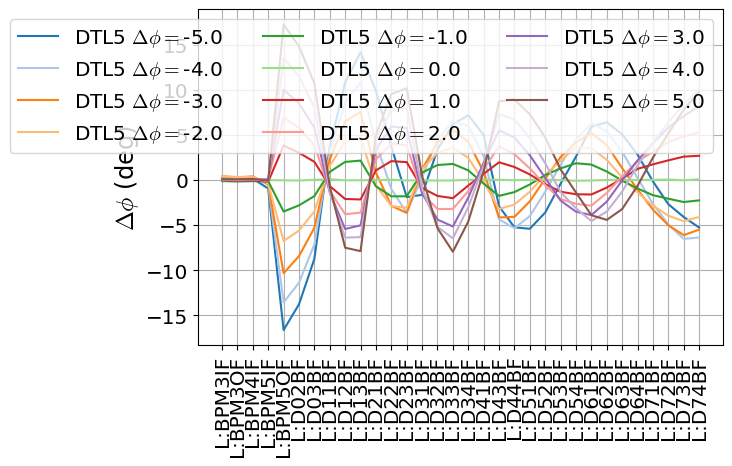

In [42]:
#%matplotlib widget
%matplotlib inline
plt.rcParams.update({'font.size': 12})
[plt.plot(ssdfmed1[0].iloc[k,2:], label='DTL5 $\Delta\phi=$%2.1f'%(ssdfmed1[0].iloc[k,1]), marker='',linestyle='-') for k in range(11) ]
#[plt.plot(ssdfmed1[1].iloc[k,2:], label='DTL2 $\Delta\phi=$%2.1f'%(ssdfmed1[1].iloc[k,0]), marker='',linestyle='-') for k in range(11) ]
#plt.plot(ssdfmed1[0].iloc[10,2:], label='DTL5 $\Delta\phi=$%2.1f'%(ssdfmed1[0].iloc[10,1]), marker='',linestyle='-')
#plt.plot(ssdfmed1[1].iloc[10,2:], label='DTL2 $\Delta\phi=$%2.1f'%(ssdfmed1[1].iloc[10,0]), marker='',linestyle='-')

plt.grid()#
plt.legend(loc="upper right",fontsize = 'large',ncol=3)
#plt.xlabel("Distance along Linac (m)")
plt.ylabel("$\Delta \phi$ (deg)")
plt.xticks(rotation = 90);
plt.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(bottom=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.16)
plt.subplots_adjust(right=0.98)

## 2-phase model: RFQ phase is fixed

In [43]:
rfqdf = []
for i in range(11):
    rfqdf.append(fetch_slice(ddfs[0],['L:RFQPAH'],[-20+i*4],[1.]))

rfqdf =[df.sort_index().reset_index(drop=True) for df in rfqdf]
rfqdf = [df.dropna() for df in rfqdf]

#rfqdfmed= [[df.groupby(np.arange(len(df))//9).median() for df in s] for s in ssdf]
rfqdfmed= [df.groupby(np.arange(len(df))//9).mean() for df in rfqdf]

<ipython-input-21-594ebfea2ea7>:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  sliced = dataset.loc[eval('&'.join(conds)).ravel()]


In [44]:
test1 = rfqdf[5].iloc[:523,:].groupby(np.arange(523)//9).mean()
test2 = rfqdf[5].iloc[522:523+7,:].groupby(np.arange(8)//8).mean()
#rfqdf[5].iloc[520:560,:3]
#test2
test3 = rfqdf[5].iloc[522:523+7,:].groupby(np.arange(8)//8).mean()
rfqdfmed[5]

,L:RFQPAH,L:V2QSET,L:V5QSET,L:BPM3IF,L:BPM3OF,L:BPM4IF,L:BPM5IF,L:BPM5OF,L:D02BF,L:D03BF,...,L:D53BF,L:D54BF,L:D61BF,L:D62BF,L:D63BF,L:D64BF,L:D71BF,L:D72BF,L:D73BF,L:D74BF
0,0.0,-3.000000,-2.0,-6.906128,-5.127563,-5.880737,5.545654,-9.896851,-6.828003,-3.605957,...,4.208374,6.151123,6.251221,3.977051,0.062256,-3.583374,-5.917358,-7.778931,-8.129883,-7.203369
1,0.0,-2.400000,-2.0,-4.987793,-3.795776,-4.339600,3.894043,-9.079590,-6.477661,-3.503418,...,3.909302,5.569458,5.414429,3.234863,-0.115356,-3.372803,-5.448608,-6.760254,-7.241821,-6.759033
2,0.0,-1.799999,-2.0,-3.116455,-2.383423,-2.891846,2.836304,-8.390503,-6.215210,-3.627319,...,3.471680,4.887695,4.806519,2.846680,-0.170288,-3.063354,-4.928589,-6.163330,-6.589355,-6.051025
3,0.0,-1.200001,-2.0,-1.707153,-1.350098,-1.732178,1.699829,-7.837524,-6.257324,-3.640747,...,3.289185,4.402466,4.349976,2.488403,-0.350952,-2.971191,-4.603882,-5.691528,-6.003418,-5.410156
4,0.0,-0.600000,-2.0,-0.734253,-0.613403,-0.976562,1.002808,-7.694092,-6.083374,-3.886108,...,2.718506,4.033203,4.184570,2.592163,-0.055542,-2.612915,-4.169312,-5.153809,-5.845337,-5.505981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.866667,2.0,1.215210,0.766602,1.007080,-0.831299,8.345947,6.837158,4.650269,...,-0.645142,-1.832275,-2.484741,-1.940308,-0.506592,1.117554,2.612305,3.630981,4.679565,5.825195
117,0.0,1.466667,2.0,2.533569,1.736450,2.077026,-1.672974,8.912964,7.176514,4.590454,...,-1.057739,-2.343140,-2.605591,-1.805420,-0.413208,1.409912,2.966919,4.031982,5.037231,6.118774
118,0.0,2.066666,2.0,3.968506,2.798462,3.259277,-2.620239,9.534912,7.528687,4.796753,...,-1.033936,-2.174683,-2.819824,-2.011719,-0.493774,1.503296,3.209839,4.506226,5.515747,6.674805
119,0.0,2.666666,2.0,5.401001,3.785400,4.374390,-3.676758,10.268555,7.805786,4.822998,...,-1.240845,-2.561035,-2.976074,-2.022095,-0.260010,1.752319,3.527222,4.677734,5.869141,7.218628


In [48]:
#train_data3 = rfqdf[5].iloc[:,1:].sample(frac=0.8, random_state=11)
#test_data3 = rfqdf[5].iloc[:,1:].drop(train_data3.index)

train_data3 = ddf1deg.sample(frac=0.8, random_state=11)
test_data3 = ddf1deg.drop(train_data3.index)

train_ft3, train_lbl3 = fetch_features_labels(train_data3,['L:V2QSET','L:V5QSET'])
test_ft3, test_lbl3 = fetch_features_labels(test_data3,['L:V2QSET','L:V5QSET'])

normal3 = preprocessing.Normalization(axis=-1)
normal3.adapt(np.array(train_ft3))

NameError: name 'preprocessing' is not defined

In [46]:
%%time

init_lr = 1e-3

model_2ph = build_and_compile_model_len(normal3, initial_lr, train_lbl3.shape[1])
model_2ph.summary()
history_2ph = train_model(model_2ph,train_ft3,train_lbl3,600,lr_time_based_decay)

NameError: name 'normal3' is not defined

In [ ]:
%matplotlib widget
plot_loss(history_2ph)

In [ ]:
#model_2ph.save('dnn_model_2ph_27042023')
# in the future, to load a trained model:
loaded_model_2ph = tf.keras.models.load_model('dnn_model_2ph_27042023')

In [ ]:
loaded_model_2ph.evaluate(test_ft3, test_lbl3, verbose=1)
testpred3 = loaded_model_2ph.predict(test_ft3)

In [ ]:
%matplotlib widget
#plot_2dhist(testpred3,test_lbl3)
plot_1derror(testpred3,test_lbl3)

In [ ]:
tt = [list(fetch_features_labels(df.iloc[:,1:],['L:V2QSET','L:V5QSET'])) for df in rfqdfmed]

preds = [loaded_model_2ph.predict(t[0]) for t in tt ]

In [ ]:
%matplotlib widget
plot_2dscatter_many(preds,[t[1] for t in tt])
#plot_2dhist(preds[5],tt[5][1])

In [ ]:
%matplotlib widget
#plot_1derror(preds[5],tt[5][1])
plot_1derror_many(preds,[t[1] for t in tt])

In [ ]:
osc1 = [fetch_slice(df,['L:V2QSET','L:V5QSET'],[0,0],[0.2,0.2]) for df in rfqdf]
osc1 = [o.mean().to_frame().transpose() for o in osc1]

[print(osc.iloc[:,:5]) for osc in osc1]

#[df.to_csv('osc_varyRFQ_fixT2T5_%d.csv'%i) for i,df in enumerate(osc1)]
#rfqdfmed[5].to_csv('osc_fixRFQ_varyT2T5.csv')

predicted = [loaded_model_2ph.predict(osc.iloc[:,3:]) for osc in osc1]
print(predicted)
osc2 = [fetch_slice(rfqdfmed[5],['L:V2QSET','L:V5QSET'],pr[0],[0.3,0.29]) for pr in predicted ]
#[print(osc.iloc[:,:3], pr[0]) for (osc,pr) in zip(osc2,predicted)]

In [ ]:
%matplotlib widget
#plt.scatter(osc1[5].iloc[:,3:],osc2[5].iloc[:,3:])
[plt.scatter(o1.mean()[9:],o2.mean()[9:], label='Data %d'%i) for i,(o1,o2) in enumerate(zip(osc1,osc2))]
plt.plot([-11,11],[-11,11],color='k', linestyle = '-')
plt.plot([-11,11],[-9,13],color='k', linestyle = '-.')
plt.plot([-11,11],[-13,9],color='k', linestyle = '-.')
plt.plot([-11,11],[-10,12],color='r', linestyle = '--')
plt.plot([-11,11],[-12,10],color='r', linestyle = '--')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('Original oscillation')
plt.ylabel('Predicted oscillation')
plt.grid()

In [ ]:
%matplotlib widget
plt.plot(dist_data[6:],osc1[1].mean()[8:], label = 'Original data 4')
plt.plot(dist_data[6:],osc2[1].mean()[8:], label = 'Predicted data 4')
plt.plot(dist_data[6:],osc1[10].mean()[8:], label = 'Original data 10')
plt.plot(dist_data[6:],osc2[10].mean()[8:], label = 'Predicted data 10')
plt.plot(dist_data[6:],osc1[0].mean()[8:], label = 'Original data 4')
plt.plot(dist_data[6:],osc2[0].mean()[8:], label = 'Predicted data 4')
#plt.xticks(rotation=90)
plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Distance along Linac (m)')
plt.ylabel('$\Delta \phi_{BPM}$ (deg)')

In [ ]:
# We interpolate the data to create larger number of grid points

from scipy.interpolate import griddata

file = './osc_fixRFQ_varyT2T5.csv' #this has T5 ref at -32.4
#dfrd = pd.read_csv(file,sep=',')
dfrd = rfqdfmed[5]


NPX=61
NPY=61

X, Y = np.mgrid[dfrd['L:V5QSET'].min():dfrd['L:V5QSET'].max():NPY*1j,
                dfrd['L:V2QSET'].min():dfrd['L:V2QSET'].max():NPX*1j]
points = (Y.ravel(),X.ravel())
bpms=dfrd.filter(regex="^(?!.*QSET|Unnamed).*").columns
if 'L:BPM2OF' in bpms:
    bpms =bpms.drop('L:BPM2OF')
print(bpms)


dfnew=pd.DataFrame(zip(Y.ravel(),X.ravel()),columns=["L:V2QSET","L:V5QSET"])
for bpm in bpms:
    dfnew[bpm] = griddata((dfrd['L:V2QSET'],dfrd['L:V5QSET']), dfrd[bpm], points, method='linear')

#print(dfnew)
#print(df)

In [ ]:
predicted[0][0] = [-1.885,0.4]
predicted[8][0] = [1.0,-0.452]
#predicted[-1][0] = [1.8,-0.494]
osc3 = [fetch_slice(dfnew,['L:V2QSET','L:V5QSET'],pr[0],[0.058,0.035]) for pr in predicted ]
[print(osc.iloc[:,:3], pr[0]) for (osc,pr) in zip(osc3,predicted)]
#print(osc3)

In [ ]:
osctest=[]
bestpred=[None]*len(predicted)
#best fits:
bestpred[0] = [-1.885,  0.652]# -20: -1.885  0.652
bestpred[1] = [-1.125,  0.427]# -16: -1.125  0.427
bestpred[2] = [-1.138,  0.362]# -12: -1.138  0.362
bestpred[3] = [-0.855,  0.23]# -8: -0.855  0.23
bestpred[4] = [-0.705,  0.166]# -4: -0.705  0.166
bestpred[5] = predicted[5][0]
bestpred[6] = predicted[6][0]
bestpred[7] = predicted[7][0]
bestpred[8] = [1.066,  -0.498]# 12:1.066 -0.498
bestpred[9] = [1.551,  -0.50]# 16: 1.8 -0.5?
bestpred[10] = [1.885,  -0.494]# 20: 1.8 -0.5?

n = 7
for i in range(n):
    predi = [1.351+i*0.1,-0.50]
    osctest.append(fetch_slice(dfnew,['L:V2QSET','L:V5QSET'],predi,[0.058,0.035]))

#%matplotlib widget
#fig, ax = plt.subplots()
#ax.plot(dist_data[7:],osc1[9].mean()[9:], label = '$\Delta\phi_{RFQ}$',color='r')
#ax.scatter(dist_data[7:],osc3[9].mean()[9:], label = 'predicted (deg)',color='k')
#for i in range(n):
#    ax.plot(dist_data[7:],osctest[i].mean()[9:], label = 'best (deg)')


best = []
for i in range(11):
    best.append(fetch_slice(dfnew,['L:V2QSET','L:V5QSET'],bestpred[i],[0.058,0.035]))
#ax.legend()

In [ ]:
%matplotlib widget

labels=np.arange(-20,21,4)
#plt.scatter(osc1[5].iloc[:,3:],osc2[5].iloc[:,3:])
osc1s = [osc1[0],osc1[1],osc1[2],osc1[3],osc1[8],osc1[9]]
osc3s = [osc3[0],osc3[1],osc3[2],osc3[3],osc3[8],osc3[9]]
labs = [labels[0],labels[1],labels[2],labels[3],labels[8],labels[9]]
[plt.scatter(o1.mean()[9:],o2.mean()[9:], label='$\Delta\phi_{RFQ}=%d^{\circ}$'%labs[i]) for i,(o1,o2) in enumerate(zip(osc1s,osc3s))]
plt.plot([-11,11],[-11,11],color='k', linestyle = '-')
plt.plot([-11,11],[-10,12],color='k', linestyle = '-.')
plt.plot([-11,11],[-12,10],color='k', linestyle = '-.')
plt.plot([-11,11],[-10.5,11.5],color='r', linestyle = '--')
plt.plot([-11,11],[-11.5,10.5],color='r', linestyle = '--')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel('$\phi_{RFQ}$ varied $\Delta\phi$ (deg)')
plt.ylabel('Predicted $\Delta\phi$ (deg)')
plt.legend(ncol=3,bbox_to_anchor=(0., .95, .9, .02),loc='lower left',borderaxespad=0.)
plt.grid()

In [ ]:
%matplotlib widget
labels=np.arange(-20,21,4)
nplots=5
fig, ax = plt.subplots(int(nplots),1, figsize=(9,3*int(nplots)),sharey=True)
for i in range(nplots):
    ax[i].plot(dist_data[7:],osc1[i].mean()[9:], label = '$\Delta\phi_{in}=%d^{\circ}$'%labels[i])
    ax[i].plot(dist_data[7:],osc3[i].mean()[9:], label = 'Predicted (T2,T5)')
    #ax[i].plot(dist_data[7:],best[i+6].mean()[9:], label = 'Best match')
    #ax[i].plot(dist_data[7:],np.subtract(osc3[i].mean()[9:],osc1[i].mean()[9:]), label = 'Residual (deg)')
    ax[i].grid()
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Distance (m)')
    ax[i].set_ylabel('$\Delta \phi_{BPM}$ (deg)')

fig.supxlabel('Distance along Linac (m)')
#fig.supylabel('$\Delta \phi_{BPM}$ (deg)')
fig.tight_layout()

plt.subplots_adjust(bottom=0.11)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.99)


In [ ]:
%matplotlib widget
nplots=6
fig, ax = plt.subplots(int(nplots),1, figsize=(9,3*int(nplots)),sharey=True)
for i in range(nplots):
    ax[i].plot(dist_data[7:],osc1[i+5].mean()[9:], label = '$\Delta\phi_{RFQ}=%d^{\circ}$'%labels[i+5])
    ax[i].plot(dist_data[7:],osc3[i+5].mean()[9:], label = 'Predicted (T2,T5)')
    ax[i].grid()
    ax[i].legend(loc='lower right')
    ax[i].set_xlabel('Distance (m)')
    ax[i].set_ylabel('$\Delta \phi_{BPM}$ (deg)')

fig.supxlabel('Distance along Linac (m)')
#fig.supylabel('$\Delta \phi_{BPM}$ (deg)')
fig.tight_layout()

plt.subplots_adjust(bottom=0.1)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.99)